# Implementando a rede para classificar dígitos

Vamos usar os dados de treino MNIST e gradiente descendente estocástico. 

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn import datasets
from sklearn.model_selection import train_test_split

Carregando a biblioteca e reajeitando para que o algoritmo compreenda. 

In [2]:
digits = datasets.load_digits(return_X_y=True)
images = datasets.load_digits().images
print(digits[0].shape)
print(digits[1].shape)
dataset = [(x.reshape(64,1),np.array(y)) for x,y in zip(digits[0], digits[1])]

(1797, 64)
(1797,)


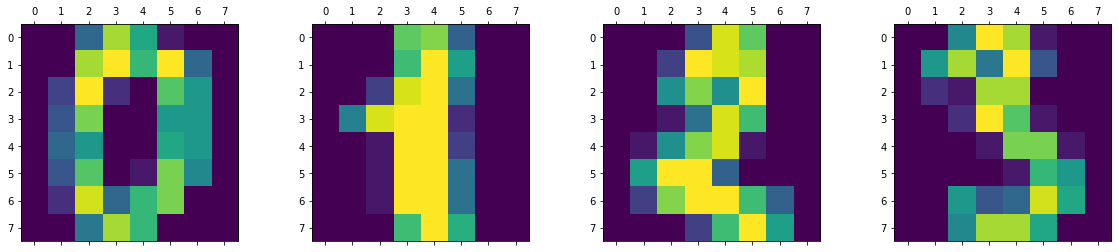

In [3]:
fig, ax = plt.subplots(1,4, figsize = (20,4))
for i in range(4):    
    ax[i].matshow(images[i]) 
plt.show() 

Separando em treino e teste:

In [4]:
training_data, test_data = train_test_split(dataset, random_state = 100)

In [9]:
class Network(object):
    
    def __init__(self, sizes, seed = 50000): 
        # Size contains the number of neurons in the respective layers. 
        self.num_layers = len(sizes)
        # Garantee reprodutibility
        self.r = np.random.RandomState(seed)
        self.sizes = sizes 
        self.biases = [self.r.randn(y, 1) for y in sizes[1:]]
        self.weights = [self.r.randn(y,x) for x, y in zip(sizes[:-1], sizes[1:])]

    def sigmoid(self,z): 
        return 1/(1 + np.exp(-z))
    
    def sigmoid_prime(self, z):
        return self.sigmoid(z)*(1 - self.sigmoid(z))
    
    def feedforward(self, a):
        
        for b, w in zip(self.biases, self.weights):
            a = self.sigmoid(w@a + b)
        return a

    def backprop(self, x, y):
        """Return a tuple ``(nabla_b, nabla_w)`` representing the
        gradient for the cost function C_x.  ``nabla_b`` and
        ``nabla_w`` are layer-by-layer lists of numpy arrays, similar
        to ``self.biases`` and ``self.weights``."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        # feedforward
        activation = x
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the z vectors, layer by layer
        for b, w in zip(self.biases, self.weights):
            z = w@activation+b
            zs.append(z)
            activation = self.sigmoid(z)
            activations.append(activation)
        # backward pass
        delta = self.cost_derivative(activations[-1], y)*self.sigmoid_prime(zs[-1])
        nabla_b[-1] = delta
        nabla_w[-1] = delta@activations[-2].transpose()

        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = self.sigmoid_prime(z)
            delta = (self.weights[-l+1].transpose()@delta)*sp
            nabla_b[-l] = delta
            nabla_w[-l] = delta@activations[-l-1].transpose()
        return(nabla_b, nabla_w)
    
    def SGD(self, training_data, epochs, mini_batch_size, eta, test_data = None):
        
        n = len(training_data)
        for j in range(epochs): 
            self.r.shuffle(training_data)
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in range(0,n,mini_batch_size)]
            for mini_batch in mini_batches:
                # eta is the learning rate
                self.update_mini_batch(mini_batch, eta)
            if test_data:
                n_test = len(test_data)
                print('Epoch {}: {}'.format(
                     j, self.evaluate(test_data)/n_test))
            else: 
                print('Epoch {} complete'.format(j))
                
    def update_mini_batch(self, mini_batch, eta):
        """Update the network's weights and biases by applying
        gradient descent using backpropagation to a single mini batch.
        The ``mini_batch`` is a list of tuples ``(x, y)``, and ``eta``
        is the learning rate."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights] 
        for x, y in mini_batch: 
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb + dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw + dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        self.weights = [w - (eta/len(mini_batch))*nw 
                       for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b - (eta/len(mini_batch))*nb 
                      for b, nb in zip(self.biases, nabla_b)]

    def evaluate(self, test_data):
        
        test_results = [(np.argmax(self.feedforward(x)),y) for (x,y) in test_data]
        return sum(x == y for (x,y) in test_results)
    
    def cost_derivative(self, output_activations, y):
        """Return the vector of partial derivarives \partial C_x / \partial a"""
        return (output_activations - y)

Iniciando o treino. 

In [10]:
net = Network([64, 30, 1])
net.SGD(training_data, 30, 10, 1000.0, test_data=test_data)

[[  50.769238  ]
 [  42.45612689]
 [  45.27825934]
 [ -48.59045785]
 [   9.52752762]
 [ -24.3355941 ]
 [ 124.76665014]
 [ -71.38895548]
 [  22.09448666]
 [  71.25350564]
 [-123.6725041 ]
 [-146.96510585]
 [-129.76910183]
 [  25.10921809]
 [  78.30293263]
 [  -7.10099241]
 [ -16.76512833]
 [  17.55525105]
 [  39.44393816]
 [-133.62736068]
 [  12.56518286]
 [ 101.24039771]
 [  -2.49180279]
 [ -69.14123627]
 [ 115.02280677]
 [  27.9762621 ]
 [ -59.50611124]
 [ -46.44170031]
 [ -55.11001213]
 [   4.2922319 ]]
[[5.80870268]]
[[5.80870268]]
[[5.80870268]]
[[  50.769238  ]
 [  42.45612689]
 [  45.27825934]
 [ -48.59045785]
 [   9.52752762]
 [ -24.3355941 ]
 [ 124.76665014]
 [ -71.38895548]
 [  22.09448666]
 [  71.25350564]
 [-123.6725041 ]
 [-146.96510585]
 [-129.76910183]
 [  25.10921809]
 [  78.30293263]
 [  -7.10099241]
 [ -16.76512833]
 [  17.55525105]
 [  39.44393816]
 [-133.62736068]
 [  12.56518286]
 [ 101.24039771]
 [  -2.49180279]
 [ -69.14123627]
 [ 115.02280677]
 [  27.9762621 ]
 [

/home/lucasmoschen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in exp
  



[[ 7.10891004e+01]
 [ 8.74599678e+01]
 [ 5.57447503e+01]
 [-1.47472708e+02]
 [-6.16714105e+01]
 [ 1.98458720e+00]
 [ 2.79055999e+01]
 [-1.30965973e+02]
 [-1.59477781e+02]
 [ 1.93180066e+01]
 [-1.39330338e+02]
 [-8.26972570e+01]
 [-9.91111725e+01]
 [ 3.34163184e+01]
 [ 1.59305081e+02]
 [-4.93797165e+02]
 [-7.01425076e+01]
 [ 3.14516739e+04]
 [ 3.97649112e+00]
 [-7.28332765e+01]
 [ 1.40980981e+03]
 [ 1.28521082e+02]
 [-9.13068676e+04]
 [ 1.23731736e+01]
 [ 1.19020735e+02]
 [ 7.27161072e+01]
 [-3.99982367e+04]
 [-8.97882486e+01]
 [-4.81121619e+02]
 [-3.41109407e+03]]
[[ 4.99756384e+01]
 [ 3.67787899e+01]
 [ 7.99245039e+01]
 [-9.78826846e+01]
 [-5.02750797e+01]
 [ 1.69986901e+01]
 [-2.94334545e+01]
 [-8.48987418e+01]
 [-1.09231793e+02]
 [-3.91820553e+01]
 [-3.21655027e+01]
 [-5.09293272e+01]
 [-2.38661625e+01]
 [-4.61369045e+01]
 [ 1.16963212e+02]
 [-3.61201435e+02]
 [-5.52243203e+01]
 [ 2.65050824e+04]
 [-2.63837598e+01]
 [-2.76396536e+01]
 [ 9.21642519e+02]
 [ 2.80460288e+01]
 [-7.62346

[[ 7.79635889e+01]
 [ 7.53941655e+01]
 [ 9.57184060e+01]
 [-2.07207291e+02]
 [-8.55687843e+01]
 [ 4.64622099e+01]
 [-2.77752202e+01]
 [-6.72630404e+01]
 [-1.08103047e+02]
 [ 2.35831927e+01]
 [-1.57544826e+02]
 [-1.52945873e+02]
 [-4.38024087e+01]
 [ 1.66003609e+01]
 [ 1.40447957e+02]
 [-5.08007395e+02]
 [-3.07632753e+01]
 [ 2.96419649e+04]
 [-1.62793841e+01]
 [-7.47338186e+01]
 [ 1.35056789e+03]
 [ 9.30619736e+01]
 [-8.62507234e+04]
 [-4.48621808e+01]
 [ 9.66574884e+01]
 [ 4.19230599e+01]
 [-3.76821280e+04]
 [-7.61964337e+01]
 [-4.04741281e+02]
 [-3.33886706e+03]]
[[930.27418131]]
[[930.27418131]]
[[930.27418131]]
[[ 7.79635889e+01]
 [ 7.53941655e+01]
 [ 9.57184060e+01]
 [-2.07207291e+02]
 [-8.55687843e+01]
 [ 4.64622099e+01]
 [-2.77752202e+01]
 [-6.72630404e+01]
 [-1.08103047e+02]
 [ 2.35831927e+01]
 [-1.57544826e+02]
 [-1.52945873e+02]
 [-4.38024087e+01]
 [ 1.66003609e+01]
 [ 1.40447957e+02]
 [-5.08007395e+02]
 [-3.07632753e+01]
 [ 2.96419649e+04]
 [-1.62793841e+01]
 [-7.47338186e+01

 [-3.14256522e+03]]
[[ 6.62923286e+01]
 [ 1.16344272e+02]
 [ 3.86086030e+01]
 [-1.06710497e+02]
 [-4.10084684e+01]
 [ 1.59567608e+01]
 [ 2.15270113e+01]
 [-9.05908583e+01]
 [-4.78898423e+01]
 [ 1.34798826e+02]
 [-2.10168570e+02]
 [-1.02219017e+02]
 [-5.52668332e+01]
 [ 4.18263786e+01]
 [ 4.08493507e+01]
 [-4.59000682e+02]
 [-6.36201329e+00]
 [ 2.35023438e+04]
 [-4.33084092e+01]
 [-3.25705249e+01]
 [ 1.19929908e+03]
 [ 9.72666907e+01]
 [-6.86260572e+04]
 [-1.91110043e+01]
 [ 8.83782713e+01]
 [ 2.50088902e+01]
 [-2.97584702e+04]
 [-5.18307055e+01]
 [-3.64976795e+02]
 [-2.93188459e+03]]
[[1022.1019339]]
[[1022.1019339]]
[[1022.1019339]]
[[ 6.62923286e+01]
 [ 1.16344272e+02]
 [ 3.86086030e+01]
 [-1.06710497e+02]
 [-4.10084684e+01]
 [ 1.59567608e+01]
 [ 2.15270113e+01]
 [-9.05908583e+01]
 [-4.78898423e+01]
 [ 1.34798826e+02]
 [-2.10168570e+02]
 [-1.02219017e+02]
 [-5.52668332e+01]
 [ 4.18263786e+01]
 [ 4.08493507e+01]
 [-4.59000682e+02]
 [-6.36201329e+00]
 [ 2.35023438e+04]
 [-4.33084092e+0

[[1012.23264719]]
[[ 6.69437649e+01]
 [ 8.19823722e+01]
 [ 9.67695115e+01]
 [-1.79830704e+02]
 [-5.08351068e+01]
 [ 1.22750525e+01]
 [-8.17930942e+01]
 [-8.72287986e+01]
 [-4.40688979e+01]
 [ 5.80087753e+01]
 [-1.71083450e+02]
 [-1.24864200e+02]
 [-4.11277466e+01]
 [ 3.43572417e+00]
 [ 3.27625461e+01]
 [-4.48341547e+02]
 [ 5.46880621e+01]
 [ 2.74227348e+04]
 [-2.38049167e+01]
 [ 3.49153233e+01]
 [ 1.04045935e+03]
 [ 1.14585818e+02]
 [-7.94864032e+04]
 [-1.36418726e+02]
 [ 7.57968784e+01]
 [ 8.34598367e+01]
 [-3.49329721e+04]
 [-1.59632231e+01]
 [-2.69501702e+02]
 [-2.63298230e+03]]
[[ 6.69437649e+01]
 [ 8.19823722e+01]
 [ 9.67695115e+01]
 [-1.79830704e+02]
 [-5.08351068e+01]
 [ 1.22750525e+01]
 [-8.17930942e+01]
 [-8.72287986e+01]
 [-4.40688979e+01]
 [ 5.80087753e+01]
 [-1.71083450e+02]
 [-1.24864200e+02]
 [-4.11277466e+01]
 [ 3.43572417e+00]
 [ 3.27625461e+01]
 [-4.48341547e+02]
 [ 5.46880621e+01]
 [ 2.74227348e+04]
 [-2.38049167e+01]
 [ 3.49153233e+01]
 [ 1.04045935e+03]
 [ 1.1458581

[[930.64988615]]
[[930.64988615]]
[[930.64988615]]
[[ 8.32198927e+01]
 [ 7.02004922e+01]
 [ 5.42115440e+01]
 [-1.15216089e+02]
 [-5.83561594e+01]
 [ 3.33133366e+00]
 [-4.41064882e+00]
 [-7.11450035e+01]
 [-5.02462079e+01]
 [ 8.17741324e+01]
 [-1.80056370e+02]
 [-6.97176252e+01]
 [-7.40104850e+01]
 [ 5.42876074e+01]
 [ 3.94729921e+01]
 [-4.36493817e+02]
 [-1.88570660e+01]
 [ 2.43130698e+04]
 [-4.84623586e+01]
 [-4.85996126e+01]
 [ 1.16090905e+03]
 [ 8.81890741e+01]
 [-7.09639557e+04]
 [-1.07360691e+01]
 [ 3.87883526e+01]
 [ 4.67416673e+01]
 [-3.08692953e+04]
 [-7.18012991e+01]
 [-3.94483706e+02]
 [-2.79799545e+03]]
[[ 8.32198927e+01]
 [ 7.02004922e+01]
 [ 5.42115440e+01]
 [-1.15216089e+02]
 [-5.83561594e+01]
 [ 3.33133366e+00]
 [-4.41064882e+00]
 [-7.11450035e+01]
 [-5.02462079e+01]
 [ 8.17741324e+01]
 [-1.80056370e+02]
 [-6.97176252e+01]
 [-7.40104850e+01]
 [ 5.42876074e+01]
 [ 3.94729921e+01]
 [-4.36493817e+02]
 [-1.88570660e+01]
 [ 2.43130698e+04]
 [-4.84623586e+01]
 [-4.85996126e+01

 [-2.13684326e+03]]
[[ 8.49163510e+01]
 [ 1.01880473e+02]
 [ 4.91636991e+01]
 [-1.27880139e+02]
 [-1.08645180e+02]
 [-1.16270294e+01]
 [ 1.09334183e+01]
 [-1.08473499e+02]
 [-1.53853066e+02]
 [-9.10235594e+00]
 [-1.18111262e+02]
 [-9.50420377e+01]
 [-9.82480488e+01]
 [ 3.94999438e+01]
 [ 1.39943440e+02]
 [-4.61702621e+02]
 [-7.55873501e+01]
 [ 2.58785926e+04]
 [-2.92751811e-02]
 [-7.34583494e+01]
 [ 1.25611378e+03]
 [ 1.03808859e+02]
 [-7.52616871e+04]
 [ 1.17593195e+00]
 [ 1.05304490e+02]
 [ 7.92313334e+01]
 [-3.29250607e+04]
 [-6.33311170e+01]
 [-3.99672743e+02]
 [-3.00392920e+03]]
[[980.71880567]]
[[980.71880567]]
[[980.71880567]]
[[ 8.49163510e+01]
 [ 1.01880473e+02]
 [ 4.91636991e+01]
 [-1.27880139e+02]
 [-1.08645180e+02]
 [-1.16270294e+01]
 [ 1.09334183e+01]
 [-1.08473499e+02]
 [-1.53853066e+02]
 [-9.10235594e+00]
 [-1.18111262e+02]
 [-9.50420377e+01]
 [-9.82480488e+01]
 [ 3.94999438e+01]
 [ 1.39943440e+02]
 [-4.61702621e+02]
 [-7.55873501e+01]
 [ 2.58785926e+04]
 [-2.92751811e-0

[[ 8.24344435e+01]
 [ 4.43754704e+01]
 [ 1.13076346e+02]
 [-1.58974872e+02]
 [-7.74771921e+01]
 [-3.31784564e+01]
 [-3.94882431e-01]
 [-5.06735715e+01]
 [-1.47670353e+02]
 [-2.31361455e+01]
 [-1.07959468e+02]
 [-1.48506311e+02]
 [-1.09556123e+02]
 [ 3.10519656e+01]
 [ 1.23682923e+02]
 [-4.67218152e+02]
 [-8.89244186e+00]
 [ 3.09682747e+04]
 [-1.77989387e+00]
 [-1.19592000e+02]
 [ 1.26643010e+03]
 [ 9.50410778e+01]
 [-8.93330247e+04]
 [-1.03240713e+02]
 [ 1.16165648e+02]
 [ 7.64995969e+01]
 [-3.95296017e+04]
 [-6.46944127e+01]
 [-3.29773804e+02]
 [-2.62368921e+03]]
[[908.52888665]]
[[908.52888665]]
[[908.52888665]]
[[ 8.24344435e+01]
 [ 4.43754704e+01]
 [ 1.13076346e+02]
 [-1.58974872e+02]
 [-7.74771921e+01]
 [-3.31784564e+01]
 [-3.94882431e-01]
 [-5.06735715e+01]
 [-1.47670353e+02]
 [-2.31361455e+01]
 [-1.07959468e+02]
 [-1.48506311e+02]
 [-1.09556123e+02]
 [ 3.10519656e+01]
 [ 1.23682923e+02]
 [-4.67218152e+02]
 [-8.89244186e+00]
 [ 3.09682747e+04]
 [-1.77989387e+00]
 [-1.19592000e+02

[[993.03666291]]
[[ 8.21890772e+01]
 [ 5.21938349e+01]
 [ 4.55334636e+01]
 [-1.16314583e+02]
 [-7.14360478e+01]
 [ 1.17625191e+01]
 [ 3.47515156e+01]
 [-1.02444951e+01]
 [-1.35434956e+02]
 [-3.55356282e+01]
 [-1.09767561e+01]
 [-1.15507030e+02]
 [-8.80674572e+01]
 [ 6.43109413e+00]
 [ 7.41152033e+01]
 [-3.80976583e+02]
 [-2.17163758e+01]
 [ 2.72559787e+04]
 [-3.29945649e+01]
 [-1.00830812e+02]
 [ 1.13201874e+03]
 [ 8.24200862e+01]
 [-7.88505190e+04]
 [ 2.21691350e+01]
 [ 1.83062945e+01]
 [ 7.28241290e+01]
 [-3.47140564e+04]
 [-1.15438958e+02]
 [-3.10069156e+02]
 [-2.76991784e+03]]
[[ 8.21890772e+01]
 [ 5.21938349e+01]
 [ 4.55334636e+01]
 [-1.16314583e+02]
 [-7.14360478e+01]
 [ 1.17625191e+01]
 [ 3.47515156e+01]
 [-1.02444951e+01]
 [-1.35434956e+02]
 [-3.55356282e+01]
 [-1.09767561e+01]
 [-1.15507030e+02]
 [-8.80674572e+01]
 [ 6.43109413e+00]
 [ 7.41152033e+01]
 [-3.80976583e+02]
 [-2.17163758e+01]
 [ 2.72559787e+04]
 [-3.29945649e+01]
 [-1.00830812e+02]
 [ 1.13201874e+03]
 [ 8.24200862

 [-1.78917124e+03]]
[[ 1.06266797e+02]
 [ 9.43010623e+01]
 [ 3.19627861e+01]
 [-1.05674189e+02]
 [-6.95543914e+01]
 [ 2.09927593e+01]
 [ 6.49841248e+01]
 [-4.04025868e+01]
 [-1.50642568e+02]
 [ 3.13755435e+01]
 [-4.25755554e+01]
 [-1.31393468e+02]
 [-7.60264849e+01]
 [ 5.65156563e+01]
 [ 5.15469077e+01]
 [-4.10144119e+02]
 [-3.16129307e+01]
 [ 2.69368468e+04]
 [-2.67340929e+01]
 [-1.01605450e+02]
 [ 1.25197880e+03]
 [ 1.15434555e+02]
 [-7.83115710e+04]
 [ 3.26067654e+01]
 [ 6.62462011e+01]
 [ 8.05385941e+01]
 [-3.41994507e+04]
 [-1.01982561e+02]
 [-3.55105337e+02]
 [-3.22228723e+03]]
[[1034.09853536]]
[[1034.09853536]]
[[1034.09853536]]
[[ 1.06266797e+02]
 [ 9.43010623e+01]
 [ 3.19627861e+01]
 [-1.05674189e+02]
 [-6.95543914e+01]
 [ 2.09927593e+01]
 [ 6.49841248e+01]
 [-4.04025868e+01]
 [-1.50642568e+02]
 [ 3.13755435e+01]
 [-4.25755554e+01]
 [-1.31393468e+02]
 [-7.60264849e+01]
 [ 5.65156563e+01]
 [ 5.15469077e+01]
 [-4.10144119e+02]
 [-3.16129307e+01]
 [ 2.69368468e+04]
 [-2.67340929

 [-2.16808284e+03]]
[[ 2.83472357e+01]
 [ 6.73187574e+01]
 [ 7.83851479e+01]
 [-1.67035899e+02]
 [-1.71503606e+01]
 [ 5.37096179e+01]
 [-1.85475542e+01]
 [-1.00759035e+02]
 [-5.87149845e+01]
 [ 4.74606484e+01]
 [-1.25828641e+02]
 [-5.84106171e+01]
 [-8.79839969e+01]
 [-2.65345070e+01]
 [ 7.62632395e+01]
 [-3.86069072e+02]
 [ 8.31091974e+01]
 [ 2.53243229e+04]
 [ 1.00647757e+01]
 [ 5.16777869e+01]
 [ 9.87028553e+02]
 [ 9.55687451e+01]
 [-7.32437804e+04]
 [-1.25246699e+02]
 [ 1.19428171e+02]
 [ 9.53993796e+01]
 [-3.23591608e+04]
 [-8.17211639e+01]
 [-2.44802995e+02]
 [-2.16808284e+03]]
[[ 5.17222799e+01]
 [ 5.69064710e+01]
 [ 8.37060033e+01]
 [-1.54892754e+02]
 [-1.33776926e+01]
 [-1.53052806e+01]
 [-7.99782577e+01]
 [-5.03960566e+01]
 [-1.51443854e+01]
 [ 4.27447882e+01]
 [-1.25658684e+02]
 [-9.90725232e+01]
 [-2.40803133e+01]
 [ 1.94755071e+01]
 [ 1.46820487e+01]
 [-3.37089536e+02]
 [ 2.32391210e+01]
 [ 2.08060654e+04]
 [-3.41289851e+00]
 [ 2.43860399e+01]
 [ 8.06379298e+02]
 [ 9.16155

 [-2.31157181e+03]]
[[1002.83430458]]
[[1002.83430458]]
[[1002.83430458]]
[[ 6.07102736e+01]
 [ 3.63634248e+01]
 [ 5.32627344e+01]
 [-9.09401058e+01]
 [ 1.74979578e+00]
 [-4.16278801e+01]
 [ 8.43304369e+01]
 [-6.34831959e+01]
 [-1.34857193e+02]
 [ 8.05287423e+01]
 [-1.25619458e+02]
 [-1.26910801e+02]
 [-9.36251022e+01]
 [ 2.79711926e+01]
 [ 5.46507080e+01]
 [-4.01275441e+02]
 [-4.16536483e+00]
 [ 2.16782902e+04]
 [-8.68499314e+00]
 [-9.18779012e+01]
 [ 1.29370230e+03]
 [ 8.87512014e+01]
 [-6.29475528e+04]
 [-4.98595129e+01]
 [ 9.20004541e+01]
 [ 4.14172875e+01]
 [-2.75975515e+04]
 [-3.49680977e+01]
 [-2.85499644e+02]
 [-2.31157181e+03]]
[[ 6.07102736e+01]
 [ 3.63634248e+01]
 [ 5.32627344e+01]
 [-9.09401058e+01]
 [ 1.74979578e+00]
 [-4.16278801e+01]
 [ 8.43304369e+01]
 [-6.34831959e+01]
 [-1.34857193e+02]
 [ 8.05287423e+01]
 [-1.25619458e+02]
 [-1.26910801e+02]
 [-9.36251022e+01]
 [ 2.79711926e+01]
 [ 5.46507080e+01]
 [-4.01275441e+02]
 [-4.16536483e+00]
 [ 2.16782902e+04]
 [-8.68499314

[[1088.67733279]]
[[ 1.65035472e+01]
 [ 6.89070823e+01]
 [ 1.99052818e+01]
 [-1.24403522e+02]
 [ 3.81357088e+01]
 [-2.24865731e+01]
 [ 9.51752139e+01]
 [-8.39689868e+01]
 [-1.39049350e+02]
 [ 5.34508173e+01]
 [-8.56114021e+01]
 [-6.96935818e+01]
 [-1.31125056e+02]
 [-7.12007582e+00]
 [ 1.37792855e+02]
 [-4.21365759e+02]
 [ 1.77989785e+01]
 [ 2.81970063e+04]
 [ 1.23029789e+01]
 [-8.48339919e+01]
 [ 1.41023635e+03]
 [ 1.28867134e+02]
 [-8.17686460e+04]
 [-6.15826869e+01]
 [ 1.05505430e+02]
 [ 6.67090610e+01]
 [-3.60003699e+04]
 [-6.68042554e+01]
 [-3.27899441e+02]
 [-2.66140250e+03]]
[[ 1.65035472e+01]
 [ 6.89070823e+01]
 [ 1.99052818e+01]
 [-1.24403522e+02]
 [ 3.81357088e+01]
 [-2.24865731e+01]
 [ 9.51752139e+01]
 [-8.39689868e+01]
 [-1.39049350e+02]
 [ 5.34508173e+01]
 [-8.56114021e+01]
 [-6.96935818e+01]
 [-1.31125056e+02]
 [-7.12007582e+00]
 [ 1.37792855e+02]
 [-4.21365759e+02]
 [ 1.77989785e+01]
 [ 2.81970063e+04]
 [ 1.23029789e+01]
 [-8.48339919e+01]
 [ 1.41023635e+03]
 [ 1.2886713

[[940.90844612]]
[[940.90844612]]
[[940.90844612]]
[[ 9.74958433e+01]
 [ 8.82843333e+01]
 [ 7.08935798e+01]
 [-1.29701006e+02]
 [-4.75644877e+01]
 [ 1.20804034e+01]
 [-1.19718937e+01]
 [-8.26609809e+01]
 [-6.25737491e+01]
 [ 8.30102473e+01]
 [-1.92325268e+02]
 [-8.51054856e+01]
 [-2.40642767e+01]
 [ 2.89579661e+01]
 [ 8.53479544e+01]
 [-4.01933929e+02]
 [-7.83593523e+01]
 [ 2.32814343e+04]
 [-2.65984933e+01]
 [-6.94896328e+01]
 [ 1.09844793e+03]
 [ 8.36732686e+01]
 [-6.81532591e+04]
 [ 1.95600777e+00]
 [ 9.55916827e+01]
 [ 3.29261357e+01]
 [-2.94840374e+04]
 [-4.11931730e+01]
 [-3.81480877e+02]
 [-2.99311389e+03]]
[[ 9.74958433e+01]
 [ 8.82843333e+01]
 [ 7.08935798e+01]
 [-1.29701006e+02]
 [-4.75644877e+01]
 [ 1.20804034e+01]
 [-1.19718937e+01]
 [-8.26609809e+01]
 [-6.25737491e+01]
 [ 8.30102473e+01]
 [-1.92325268e+02]
 [-8.51054856e+01]
 [-2.40642767e+01]
 [ 2.89579661e+01]
 [ 8.53479544e+01]
 [-4.01933929e+02]
 [-7.83593523e+01]
 [ 2.32814343e+04]
 [-2.65984933e+01]
 [-6.94896328e+01

 [-3.10506948e+03]]
[[942.41507387]]
[[942.41507387]]
[[942.41507387]]
[[ 8.55626753e+01]
 [ 8.96586477e+01]
 [ 5.03269017e+01]
 [-1.10721385e+02]
 [-3.77117759e+01]
 [ 3.42896327e+01]
 [-1.00910854e+01]
 [-1.17249885e+02]
 [-6.96718561e+01]
 [ 9.61937745e+01]
 [-1.99972864e+02]
 [-4.55936879e+01]
 [-3.57715640e+01]
 [ 3.48161316e+01]
 [ 8.52742915e+01]
 [-4.41100843e+02]
 [-6.83423651e+01]
 [ 2.40934322e+04]
 [-2.82848122e+01]
 [-4.72714929e+01]
 [ 1.20397311e+03]
 [ 9.16792767e+01]
 [-7.05739342e+04]
 [ 9.97540062e+00]
 [ 9.58885871e+01]
 [ 3.46398272e+01]
 [-3.05083840e+04]
 [-5.63574744e+01]
 [-4.08160564e+02]
 [-3.10506948e+03]]
[[ 8.55626753e+01]
 [ 8.96586477e+01]
 [ 5.03269017e+01]
 [-1.10721385e+02]
 [-3.77117759e+01]
 [ 3.42896327e+01]
 [-1.00910854e+01]
 [-1.17249885e+02]
 [-6.96718561e+01]
 [ 9.61937745e+01]
 [-1.99972864e+02]
 [-4.55936879e+01]
 [-3.57715640e+01]
 [ 3.48161316e+01]
 [ 8.52742915e+01]
 [-4.41100843e+02]
 [-6.83423651e+01]
 [ 2.40934322e+04]
 [-2.82848122e+0

 [-2.52113611e+03]]
[[930.21478931]]
[[930.21478931]]
[[930.21478931]]
[[ 5.11801441e+01]
 [ 4.59272238e+01]
 [ 6.01052367e+01]
 [-1.14493448e+02]
 [-5.72319979e+01]
 [ 5.86556350e+00]
 [-2.18906168e+01]
 [-6.54662022e+01]
 [-5.95672712e+01]
 [ 4.62888814e+01]
 [-1.07383096e+02]
 [-5.33467956e+01]
 [-9.17073892e+01]
 [ 2.36934373e+01]
 [ 4.56383464e+01]
 [-4.12206401e+02]
 [-8.87584115e+01]
 [ 2.42531005e+04]
 [-5.23398152e+01]
 [-2.48322163e+01]
 [ 1.08998887e+03]
 [ 5.08992222e+01]
 [-7.02327889e+04]
 [-3.31903841e+01]
 [ 2.31870974e+01]
 [ 5.35191430e+01]
 [-3.09517393e+04]
 [-4.77449909e+01]
 [-3.08191955e+02]
 [-2.52113611e+03]]
[[ 5.11801441e+01]
 [ 4.59272238e+01]
 [ 6.01052367e+01]
 [-1.14493448e+02]
 [-5.72319979e+01]
 [ 5.86556350e+00]
 [-2.18906168e+01]
 [-6.54662022e+01]
 [-5.95672712e+01]
 [ 4.62888814e+01]
 [-1.07383096e+02]
 [-5.33467956e+01]
 [-9.17073892e+01]
 [ 2.36934373e+01]
 [ 4.56383464e+01]
 [-4.12206401e+02]
 [-8.87584115e+01]
 [ 2.42531005e+04]
 [-5.23398152e+0

[[ 3.65865769e+01]
 [ 1.11608591e+01]
 [ 4.35343208e+01]
 [-1.08735934e+02]
 [-4.81438134e+01]
 [ 1.48863106e+01]
 [ 1.80281989e+01]
 [-1.63371951e+01]
 [-9.97180939e+01]
 [-4.40616365e+01]
 [-3.22766410e+01]
 [-8.62118977e+01]
 [-5.91241638e+01]
 [-1.10988222e+01]
 [ 5.69607417e+01]
 [-3.13224091e+02]
 [ 2.06765404e+01]
 [ 2.14142473e+04]
 [-2.85783586e+01]
 [-5.22655108e+01]
 [ 8.99066024e+02]
 [ 2.55990715e+01]
 [-6.16611884e+04]
 [-3.53712252e+01]
 [-5.21613718e+00]
 [ 5.24576832e+01]
 [-2.73536756e+04]
 [-5.22569430e+01]
 [-2.14549971e+02]
 [-1.79304792e+03]]
[[945.05773298]]
[[945.05773298]]
[[945.05773298]]
[[ 3.65865769e+01]
 [ 1.11608591e+01]
 [ 4.35343208e+01]
 [-1.08735934e+02]
 [-4.81438134e+01]
 [ 1.48863106e+01]
 [ 1.80281989e+01]
 [-1.63371951e+01]
 [-9.97180939e+01]
 [-4.40616365e+01]
 [-3.22766410e+01]
 [-8.62118977e+01]
 [-5.91241638e+01]
 [-1.10988222e+01]
 [ 5.69607417e+01]
 [-3.13224091e+02]
 [ 2.06765404e+01]
 [ 2.14142473e+04]
 [-2.85783586e+01]
 [-5.22655108e+01

[[1099.8093559]]
[[ 1.22802228e+02]
 [ 6.85858449e+01]
 [ 1.15077334e+02]
 [-1.73392515e+02]
 [-8.90687642e+01]
 [ 3.18904749e+01]
 [-5.79397397e+01]
 [-3.22169489e+01]
 [-1.01598750e+02]
 [-3.38960476e+01]
 [-1.08368950e+02]
 [-1.39680336e+02]
 [-6.45482334e+00]
 [ 5.51600961e+01]
 [ 1.56066073e+02]
 [-3.40084636e+02]
 [-9.01227112e+01]
 [ 2.10267795e+04]
 [-3.83920708e+01]
 [-1.07963974e+02]
 [ 8.50627755e+02]
 [ 5.53859255e+01]
 [-6.10728098e+04]
 [-2.81514741e+01]
 [ 4.01770044e+01]
 [ 4.75463339e+01]
 [-2.66565618e+04]
 [-3.78819821e+01]
 [-2.83287757e+02]
 [-2.34011119e+03]]
[[889.24433304]]
[[ 1.95036099e+01]
 [ 6.33455569e+01]
 [ 3.19363363e+01]
 [-1.60887364e+02]
 [-6.26100841e+01]
 [-3.22887093e+01]
 [-7.19498344e+01]
 [-3.93234251e+01]
 [-2.96144619e+01]
 [ 3.68021356e+01]
 [-1.02756074e+02]
 [-1.11300210e+02]
 [-6.18568629e+01]
 [ 7.70409587e+01]
 [ 8.77131061e+01]
 [-3.29253260e+02]
 [ 2.78390366e+01]
 [ 2.47386785e+04]
 [-5.23031512e+01]
 [-1.71204818e+01]
 [ 8.51983746e+

[[ 3.89401825e+01]
 [ 4.45473522e+01]
 [ 6.40801756e+01]
 [-1.42931768e+02]
 [-1.05134341e+02]
 [ 6.99578051e+01]
 [ 5.29652293e+01]
 [-6.23654852e+01]
 [-1.49401986e+02]
 [ 1.77394393e+01]
 [-7.90196333e+01]
 [-1.68312529e+02]
 [-3.95959122e+01]
 [ 3.80733547e+00]
 [ 1.23880346e+02]
 [-4.25860664e+02]
 [ 4.65774735e+01]
 [ 2.00354090e+04]
 [ 2.21779357e+01]
 [-2.11403736e+01]
 [ 1.10493384e+03]
 [ 4.84766836e+01]
 [-5.81572484e+04]
 [-5.53511646e+01]
 [ 8.38460271e+01]
 [ 2.81771466e+01]
 [-2.55010498e+04]
 [-6.48665935e+01]
 [-2.73150022e+02]
 [-2.11083605e+03]]
[[1126.81216558]]
[[ 2.68340752e+01]
 [ 8.05238890e+01]
 [ 4.38758933e+01]
 [-1.35045484e+02]
 [-1.03109646e+02]
 [-1.43999991e+01]
 [ 6.39534516e+01]
 [-1.04384399e+02]
 [-1.51100487e+02]
 [ 5.00155713e+01]
 [-1.42665553e+02]
 [-1.33549844e+02]
 [-1.22314335e+02]
 [ 3.15814251e+01]
 [ 9.56240165e+01]
 [-5.12524995e+02]
 [-3.03505629e+01]
 [ 2.44316842e+04]
 [ 5.64609597e-01]
 [-9.08736967e+01]
 [ 1.44019656e+03]
 [ 1.0100109

[[1012.88259666]]
[[1012.88259666]]
[[1012.88259666]]
[[ 4.37424348e+01]
 [ 1.18812461e+02]
 [ 7.09737758e+01]
 [-1.85913415e+02]
 [-2.10470177e+00]
 [ 1.03834307e+01]
 [-1.14364127e+01]
 [-9.80915920e+01]
 [-6.42249698e+01]
 [ 9.30386898e+01]
 [-1.43854490e+02]
 [-1.40586507e+02]
 [-4.30161258e+01]
 [ 1.72388235e+01]
 [ 5.95034763e+01]
 [-4.39688682e+02]
 [ 5.26118340e+01]
 [ 2.73522008e+04]
 [-2.40743436e+01]
 [ 9.43276168e+00]
 [ 1.16428269e+03]
 [ 1.49029512e+02]
 [-7.94692733e+04]
 [-1.31629377e+02]
 [ 1.07918550e+02]
 [ 8.64374017e+01]
 [-3.47796315e+04]
 [-2.11196236e+01]
 [-2.93982611e+02]
 [-2.90108985e+03]]
[[ 4.37424348e+01]
 [ 1.18812461e+02]
 [ 7.09737758e+01]
 [-1.85913415e+02]
 [-2.10470177e+00]
 [ 1.03834307e+01]
 [-1.14364127e+01]
 [-9.80915920e+01]
 [-6.42249698e+01]
 [ 9.30386898e+01]
 [-1.43854490e+02]
 [-1.40586507e+02]
 [-4.30161258e+01]
 [ 1.72388235e+01]
 [ 5.95034763e+01]
 [-4.39688682e+02]
 [ 5.26118340e+01]
 [ 2.73522008e+04]
 [-2.40743436e+01]
 [ 9.43276168e

[[ 8.17933026e+01]
 [ 1.44830786e+02]
 [ 4.66811105e+00]
 [-7.73137656e+01]
 [-7.51541144e+01]
 [-4.05648777e+01]
 [ 2.81041045e+01]
 [-1.37791778e+02]
 [-7.25491518e+01]
 [ 4.85387925e+01]
 [-1.04741165e+02]
 [-5.14924099e+01]
 [-8.32724627e+00]
 [ 6.85149419e+01]
 [ 8.34883763e+01]
 [-3.54022067e+02]
 [-1.02483470e+02]
 [ 2.02213267e+04]
 [-4.80681434e+01]
 [-7.56500897e+01]
 [ 9.60133442e+02]
 [ 9.81267881e+01]
 [-5.93372055e+04]
 [ 7.68210455e+01]
 [ 5.39011504e+01]
 [ 5.62097429e+01]
 [-2.55124362e+04]
 [-5.69159014e+01]
 [-4.13763069e+02]
 [-2.92648695e+03]]
[[1012.28793698]]
[[1012.28793698]]
[[1012.28793698]]
[[ 8.17933026e+01]
 [ 1.44830786e+02]
 [ 4.66811105e+00]
 [-7.73137656e+01]
 [-7.51541144e+01]
 [-4.05648777e+01]
 [ 2.81041045e+01]
 [-1.37791778e+02]
 [-7.25491518e+01]
 [ 4.85387925e+01]
 [-1.04741165e+02]
 [-5.14924099e+01]
 [-8.32724627e+00]
 [ 6.85149419e+01]
 [ 8.34883763e+01]
 [-3.54022067e+02]
 [-1.02483470e+02]
 [ 2.02213267e+04]
 [-4.80681434e+01]
 [-7.56500897e

 [-2.40097528e+03]]
[[1062.80086962]]
[[1062.80086962]]
[[1062.80086962]]
[[ 7.55784094e+01]
 [ 5.64255509e+01]
 [ 5.52965968e+01]
 [-1.21789513e+02]
 [-8.93054490e+01]
 [ 1.42877081e+01]
 [ 2.61608969e+01]
 [-3.35543112e+01]
 [-1.24108453e+02]
 [-2.41872154e+01]
 [-6.32966244e+01]
 [-1.39543603e+02]
 [-7.15302883e+01]
 [ 5.57141960e+01]
 [ 6.41960451e+01]
 [-3.67704339e+02]
 [ 1.54661498e+01]
 [ 2.32213654e+04]
 [-4.09184052e+01]
 [-1.13762289e+02]
 [ 1.09571590e+03]
 [ 4.94446355e+01]
 [-6.72969180e+04]
 [-2.14538750e+01]
 [ 2.10215821e+01]
 [ 4.78742319e+01]
 [-2.95062829e+04]
 [-8.02601985e+01]
 [-3.11433913e+02]
 [-2.40097528e+03]]
[[ 7.55784094e+01]
 [ 5.64255509e+01]
 [ 5.52965968e+01]
 [-1.21789513e+02]
 [-8.93054490e+01]
 [ 1.42877081e+01]
 [ 2.61608969e+01]
 [-3.35543112e+01]
 [-1.24108453e+02]
 [-2.41872154e+01]
 [-6.32966244e+01]
 [-1.39543603e+02]
 [-7.15302883e+01]
 [ 5.57141960e+01]
 [ 6.41960451e+01]
 [-3.67704339e+02]
 [ 1.54661498e+01]
 [ 2.32213654e+04]
 [-4.09184052

[[ 8.73726893e+01]
 [ 8.43372927e+01]
 [ 3.96341394e+01]
 [-1.72330233e+02]
 [-9.11899584e+00]
 [ 5.30864622e+01]
 [ 3.82837849e+01]
 [-3.35233392e+01]
 [-9.47633420e+01]
 [ 7.07191686e+01]
 [-1.34749726e+02]
 [-1.57075089e+02]
 [-9.60198723e+01]
 [ 5.78324067e+00]
 [ 1.32977281e+02]
 [-4.50339118e+02]
 [ 1.82940261e+01]
 [ 2.55835539e+04]
 [ 8.50729717e+00]
 [-5.35078392e+01]
 [ 1.31093738e+03]
 [ 1.19440986e+02]
 [-7.44876676e+04]
 [-9.07899505e+01]
 [ 1.00850795e+02]
 [ 4.17677893e+01]
 [-3.25790372e+04]
 [-9.23866181e+01]
 [-2.86716702e+02]
 [-2.86761116e+03]]
[[1127.14841271]]
[[1127.14841271]]
[[1127.14841271]]
[[ 8.73726893e+01]
 [ 8.43372927e+01]
 [ 3.96341394e+01]
 [-1.72330233e+02]
 [-9.11899584e+00]
 [ 5.30864622e+01]
 [ 3.82837849e+01]
 [-3.35233392e+01]
 [-9.47633420e+01]
 [ 7.07191686e+01]
 [-1.34749726e+02]
 [-1.57075089e+02]
 [-9.60198723e+01]
 [ 5.78324067e+00]
 [ 1.32977281e+02]
 [-4.50339118e+02]
 [ 1.82940261e+01]
 [ 2.55835539e+04]
 [ 8.50729717e+00]
 [-5.35078392e

 [-3.43987364e+03]]
[[ 6.53441672e+01]
 [ 1.25248621e+02]
 [ 8.18537257e+01]
 [-1.83821915e+02]
 [ 6.48283863e+00]
 [ 4.28583140e+01]
 [ 5.64631730e+01]
 [-8.81383867e+01]
 [-1.43913203e+02]
 [ 4.93853798e+01]
 [-1.35086355e+02]
 [-1.78488613e+02]
 [-7.89255051e+01]
 [ 8.07979877e+00]
 [ 1.34556680e+02]
 [-5.29028729e+02]
 [ 9.28665234e+00]
 [ 2.86766685e+04]
 [ 1.93487272e+01]
 [-8.65065230e+01]
 [ 1.50594254e+03]
 [ 1.42529905e+02]
 [-8.33604467e+04]
 [-9.49890693e+01]
 [ 1.45990050e+02]
 [ 4.42725878e+01]
 [-3.64828056e+04]
 [-1.01267033e+02]
 [-3.36322521e+02]
 [-3.06102945e+03]]
[[1127.92656647]]
[[1127.92656647]]
[[1127.92656647]]
[[ 6.53441672e+01]
 [ 1.25248621e+02]
 [ 8.18537257e+01]
 [-1.83821915e+02]
 [ 6.48283863e+00]
 [ 4.28583140e+01]
 [ 5.64631730e+01]
 [-8.81383867e+01]
 [-1.43913203e+02]
 [ 4.93853798e+01]
 [-1.35086355e+02]
 [-1.78488613e+02]
 [-7.89255051e+01]
 [ 8.07979877e+00]
 [ 1.34556680e+02]
 [-5.29028729e+02]
 [ 9.28665234e+00]
 [ 2.86766685e+04]
 [ 1.93487272

 [-1.97856406e+03]]
[[ 3.26829223e+01]
 [ 5.76218563e+01]
 [ 4.71734930e+01]
 [-9.69655141e+01]
 [-6.63032422e+00]
 [ 1.83586208e+01]
 [ 2.19181882e+01]
 [-9.91592085e+01]
 [-2.73371302e+01]
 [ 8.20109196e+01]
 [-1.22039575e+02]
 [-5.44281777e+01]
 [-1.27225435e+02]
 [-1.77377026e+01]
 [ 7.13082451e+01]
 [-3.40913280e+02]
 [ 1.35391306e+01]
 [ 2.22925895e+04]
 [-5.01651215e+00]
 [ 2.99881449e+01]
 [ 9.49793044e+02]
 [ 6.89208819e+01]
 [-6.45566953e+04]
 [-9.59415018e+01]
 [ 1.06555819e+02]
 [ 5.87901078e+01]
 [-2.84653682e+04]
 [-4.49266028e+01]
 [-2.29574520e+02]
 [-1.97856406e+03]]
[[ 6.12332144e+01]
 [ 6.92302300e+00]
 [ 6.59389192e+01]
 [-1.28870178e+02]
 [-3.18596511e+01]
 [ 1.87039004e+01]
 [-3.04366757e+01]
 [-4.61450290e+01]
 [-6.30417553e+01]
 [-9.85790271e+00]
 [-7.93434751e+01]
 [-6.60495191e+01]
 [-6.74386013e+01]
 [ 1.35767893e+01]
 [ 6.69177067e+01]
 [-3.77211942e+02]
 [-5.32971374e+01]
 [ 2.44779272e+04]
 [-1.59609870e+01]
 [-3.90745822e+01]
 [ 1.03023138e+03]
 [ 3.76651

[[ 7.26000057e+01]
 [ 5.19353649e+01]
 [ 8.96256711e+01]
 [-1.60246865e+02]
 [-4.57532081e+01]
 [ 3.41767014e+01]
 [ 3.39507384e+00]
 [-8.43279410e+01]
 [-1.13083644e+02]
 [ 1.52090373e+01]
 [-1.20722553e+02]
 [-1.50777698e+02]
 [-6.39426266e+01]
 [-1.57512385e+01]
 [ 1.25398870e+02]
 [-4.87551849e+02]
 [-1.99131919e+01]
 [ 2.92648076e+04]
 [-3.13867062e+01]
 [-9.38197100e+01]
 [ 1.31055125e+03]
 [ 4.12009460e+01]
 [-8.47113431e+04]
 [-1.12553628e+02]
 [ 4.72310334e+01]
 [ 1.02860463e+02]
 [-3.73149534e+04]
 [-8.17654669e+01]
 [-3.57245592e+02]
 [-2.41277157e+03]]
[[1000.71292933]]
[[1000.71292933]]
[[1000.71292933]]
[[ 7.26000057e+01]
 [ 5.19353649e+01]
 [ 8.96256711e+01]
 [-1.60246865e+02]
 [-4.57532081e+01]
 [ 3.41767014e+01]
 [ 3.39507384e+00]
 [-8.43279410e+01]
 [-1.13083644e+02]
 [ 1.52090373e+01]
 [-1.20722553e+02]
 [-1.50777698e+02]
 [-6.39426266e+01]
 [-1.57512385e+01]
 [ 1.25398870e+02]
 [-4.87551849e+02]
 [-1.99131919e+01]
 [ 2.92648076e+04]
 [-3.13867062e+01]
 [-9.38197100e

[[ 2.78215138e+01]
 [ 2.48026682e+01]
 [ 3.92195006e+01]
 [-8.34057383e+01]
 [-2.44547383e+01]
 [ 6.25653087e+00]
 [ 2.40400430e+01]
 [-5.64593181e+01]
 [-5.33299908e+01]
 [ 2.30281451e+00]
 [-9.20530879e+01]
 [-2.68502686e+01]
 [-5.69385739e+01]
 [-3.39130521e+01]
 [ 5.35665435e+01]
 [-3.60248137e+02]
 [ 3.01350034e+00]
 [ 2.60974418e+04]
 [ 2.52267737e+01]
 [-4.86986653e+01]
 [ 1.10732822e+03]
 [ 8.54525180e+01]
 [-7.54505549e+04]
 [-1.33712399e+01]
 [ 6.10704083e+01]
 [ 6.71154505e+01]
 [-3.32667214e+04]
 [-8.44501360e+01]
 [-3.31411593e+02]
 [-2.29109847e+03]]
[[1101.33354687]]
[[1101.33354687]]
[[1101.33354687]]
[[ 2.78215138e+01]
 [ 2.48026682e+01]
 [ 3.92195006e+01]
 [-8.34057383e+01]
 [-2.44547383e+01]
 [ 6.25653087e+00]
 [ 2.40400430e+01]
 [-5.64593181e+01]
 [-5.33299908e+01]
 [ 2.30281451e+00]
 [-9.20530879e+01]
 [-2.68502686e+01]
 [-5.69385739e+01]
 [-3.39130521e+01]
 [ 5.35665435e+01]
 [-3.60248137e+02]
 [ 3.01350034e+00]
 [ 2.60974418e+04]
 [ 2.52267737e+01]
 [-4.86986653e

 [-2.84221116e+03]]
[[ 8.36656839e+01]
 [ 7.84502363e+01]
 [ 7.56315630e+01]
 [-1.94918156e+02]
 [-4.97161709e+00]
 [ 6.68897880e+01]
 [ 2.20627718e+01]
 [-6.54016319e+01]
 [-1.03506032e+02]
 [ 3.65382497e+01]
 [-1.14489184e+02]
 [-1.41547014e+02]
 [-8.75576954e+01]
 [ 1.12023518e+01]
 [ 1.46410613e+02]
 [-4.76482792e+02]
 [ 2.95964388e+01]
 [ 2.81220870e+04]
 [ 1.87284795e+01]
 [-4.69321745e+01]
 [ 1.37768493e+03]
 [ 1.02178488e+02]
 [-8.15978679e+04]
 [-1.27685237e+02]
 [ 1.27934608e+02]
 [ 7.74753561e+01]
 [-3.58147928e+04]
 [-1.13733039e+02]
 [-2.73409504e+02]
 [-2.84221116e+03]]
[[ 9.73717725e+01]
 [ 7.07188434e+01]
 [ 5.73973927e+01]
 [-1.57630855e+02]
 [-1.22017577e+00]
 [ 5.81956632e+01]
 [ 6.64564665e+01]
 [-3.39437758e+01]
 [-1.09588606e+02]
 [ 3.63881312e+01]
 [-7.97006227e+01]
 [-1.32500437e+02]
 [-4.36175770e+01]
 [-1.72747834e+01]
 [ 1.58001164e+02]
 [-4.30289048e+02]
 [ 5.70940686e+01]
 [ 2.71427031e+04]
 [ 7.97729676e+00]
 [-5.96786576e+01]
 [ 1.29795239e+03]
 [ 1.13315

 [-2.93565150e+03]]
[[ 2.31959255e+01]
 [ 4.49251998e+01]
 [ 4.19233642e+01]
 [-1.23238053e+02]
 [ 3.12264613e+01]
 [-1.13667083e+01]
 [ 9.75725274e+01]
 [-8.54790376e+01]
 [-1.18615222e+02]
 [ 6.57774033e+01]
 [-1.11905330e+02]
 [-6.58719700e+01]
 [-1.05843586e+02]
 [-3.20394112e+01]
 [ 1.09654091e+02]
 [-4.46252220e+02]
 [ 3.29791086e+01]
 [ 2.76315502e+04]
 [ 2.33744074e+01]
 [-7.34202919e+01]
 [ 1.39301558e+03]
 [ 1.32051932e+02]
 [-8.00264472e+04]
 [-5.68360396e+01]
 [ 1.12649089e+02]
 [ 5.82028765e+01]
 [-3.52730023e+04]
 [-6.36035707e+01]
 [-3.09744709e+02]
 [-2.58964128e+03]]
[[1088.66292521]]
[[1088.66292521]]
[[1088.66292521]]
[[ 2.31959255e+01]
 [ 4.49251998e+01]
 [ 4.19233642e+01]
 [-1.23238053e+02]
 [ 3.12264613e+01]
 [-1.13667083e+01]
 [ 9.75725274e+01]
 [-8.54790376e+01]
 [-1.18615222e+02]
 [ 6.57774033e+01]
 [-1.11905330e+02]
 [-6.58719700e+01]
 [-1.05843586e+02]
 [-3.20394112e+01]
 [ 1.09654091e+02]
 [-4.46252220e+02]
 [ 3.29791086e+01]
 [ 2.76315502e+04]
 [ 2.33744074

[[ 8.65185633e+01]
 [ 1.10170877e+02]
 [ 5.25619178e+01]
 [-1.40714241e+02]
 [-3.20544944e+01]
 [ 4.74912855e+01]
 [ 3.36006853e+01]
 [-1.14968884e+02]
 [-1.28375323e+02]
 [ 6.84972317e+01]
 [-1.54628338e+02]
 [-1.10657623e+02]
 [-5.15192083e+01]
 [ 4.32426242e+01]
 [ 1.24871648e+02]
 [-4.88582395e+02]
 [-5.71840664e+01]
 [ 2.35983651e+04]
 [ 1.87422411e+01]
 [-7.15157063e+01]
 [ 1.41390602e+03]
 [ 8.77547265e+01]
 [-6.89860892e+04]
 [-5.17655142e+01]
 [ 1.23103955e+02]
 [ 5.51274465e+01]
 [-2.99077731e+04]
 [-7.66326277e+01]
 [-3.73869731e+02]
 [-2.95181342e+03]]
[[1045.33677552]]
[[1045.33677552]]
[[1045.33677552]]
[[ 8.65185633e+01]
 [ 1.10170877e+02]
 [ 5.25619178e+01]
 [-1.40714241e+02]
 [-3.20544944e+01]
 [ 4.74912855e+01]
 [ 3.36006853e+01]
 [-1.14968884e+02]
 [-1.28375323e+02]
 [ 6.84972317e+01]
 [-1.54628338e+02]
 [-1.10657623e+02]
 [-5.15192083e+01]
 [ 4.32426242e+01]
 [ 1.24871648e+02]
 [-4.88582395e+02]
 [-5.71840664e+01]
 [ 2.35983651e+04]
 [ 1.87422411e+01]
 [-7.15157063e

KeyboardInterrupt: 